# Проект «Обучение с учителем: качество модели»

### Описание задачи

Мы работаем в Интернет-магазине «В один клик», который продает разные товары: для детей, для дома, мепкую бытовую технику, косметику,
продукты и прочее.
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.
Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории.
Возможный выход — удерживать активность постоянных клиентов. 
Сделать это можно с помощью персонализированных предложений.

#### Постановка задачи

Нам необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую
активность.

### Описание данных

Мы имеем 4 (четыре) датасета:
* market_file.csv — датасет, который содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом
  поведении.
* market_money.csv — датасет с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период
  взаимодействия с сайтом.
* market_time.csv — датасет с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* money.csv — датасет с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому
  покупателю.

## Загрузка библиотек

In [1]:
!pip install shap

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [2]:
!pip install phik

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import pandas as pd
import phik
from matplotlib import pyplot
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

## Загрузка данных

In [4]:
filename_market_file = 'market_file.csv'
filename_market_money = 'market_money.csv'
filename_market_time = 'market_time.csv'
filename_money = 'money.csv'

In [5]:
try:
    data_market_file = pd.read_csv('/datasets/' + filename_market_file)
except:
    data_market_file = pd.read_csv(filename_market_file)

In [6]:
try:
    data_market_money = pd.read_csv('/datasets/' + filename_market_money)
except:
    data_market_money = pd.read_csv(filename_market_money)

In [7]:
try:
    data_market_time = pd.read_csv('/datasets/' + filename_market_time)
except:
    data_market_time = pd.read_csv(filename_market_time)

In [8]:
try:
    data_money = pd.read_csv('/datasets/' + filename_money)
except:
    data_money = pd.read_csv(filename_money)

#### Осмотр данных

Посмотрим на датасеты

##### market_file

In [9]:
data_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Видим, что датасет полный (без NaN'ов).
Есть непостоянство стиля в наименовании столбцов (где-то слова через пробел, где-то — через нижнее подчеркивание).

Посмотрим первые 5 строк.

In [10]:
data_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Датасет загрузился корректно.
Данные в датасете соответствуют описанию.

##### market_money

In [11]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Датасет полный.

Посмотрим на первые 5 строк

In [12]:
data_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Датасет загрузился корректно.
Данные в датасете соответствуют описанию.

##### market_time

In [13]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Датасет полный (нет NaN'ов). Непостоянство стиля в наименовании столбцов (столбец наименован не с заглавной буквы)

Посмотрим на первые 5 строк

In [14]:
data_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Датасет загрузился корректно.
Данные в датасете соответствуют описанию.

##### money

In [15]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


Видим, что из названия столбца выходит, что разделителем должен быть знак ';'.
Проверим это, взглянув на первые 5 строк данных.

In [16]:
data_money.head()

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


Видим, что данные загрузились не вполне корректно.
Разделителем данных (delimiter) служит знак ';', а десятичным разделителем (decimal) — знак ','.

Перезагрузим данные с учетом этих особенностей.

In [17]:
try:
    data_money = pd.read_csv('/datasets/' + filename_money, delimiter=';', decimal=',')
except:
    data_money = pd.read_csv(filename_money, delimiter=';', decimal=',')

In [18]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Датасет полный.

Посмотрим на первые 5 строк.

In [19]:
data_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Теперь все загрузилось корректно.
Данные в датасете соответствуют описанию.

#### Переименование столбцов

Наименования столбцов оставим кириллическими, но для единообразия и удобства в ряде столбцов заменим пробелы на нижнее подчеркивание,
а также названия стобцов сделаем прописными буквами.

In [20]:
data_market_file = data_market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать',
    'Покупательская активность': 'Покупательская_активность'
})

In [21]:
data_market_time = data_market_time.rename(columns={
    'минут': 'Минут'
})

## Предобработка данных

#### market_file

Посмотрим еще раз на датасет

In [22]:
data_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Взглянем на первые 5 строк

In [23]:
data_market_file.head()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Проверим уникальные значения строковые признаков на предмет наличия дубликатов и прочих аномальных значений.

In [24]:
data_market_file['Покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

Все значения уникальны, повторов и выбивающихся из нормы значений нет.

In [25]:
data_market_file['Тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Видим очевидный повтор слов «стандартт» и «стандарт».
Исправим это, заодно поменяем написание значений признака на аналогичные, но с начальной прописной буквой.

In [26]:
data_market_file.loc[data_market_file['Тип_сервиса'] == 'стандартт', 'Тип_сервиса'] = 'Стандарт'

In [27]:
data_market_file.loc[data_market_file['Тип_сервиса'] == 'стандарт', 'Тип_сервиса'] = 'Стандарт'

In [28]:
data_market_file.loc[data_market_file['Тип_сервиса'] == 'премиум', 'Тип_сервиса'] = 'Премиум'

Посмотрим на следующий признак.

In [29]:
data_market_file['Разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

Повторов нет, но, по аналогии выше, заменим строчную букву в начале значений признака на прописную.

In [30]:
data_market_file.loc[data_market_file['Разрешить_сообщать'] == 'да', 'Разрешить_сообщать'] = 'Да'

In [31]:
data_market_file.loc[data_market_file['Разрешить_сообщать'] == 'нет', 'Разрешить_сообщать'] = 'Нет'

Проверим последний строковый признак «Популярная_категория»

In [32]:
data_market_file['Популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Здесь все корректно: повторов и аномальных значений нет и написание значений признаков соответствует стилю (с прописной буквы).

##### Очистка данных

Проверим датасет на дубликаты

In [33]:
data_market_file.duplicated().sum()

np.int64(0)

Дубликатов нет.

#### market_money

In [34]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Взглянем на первые 5 строк

In [35]:
data_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Проверим признак «Период» на уникальные и аномальные значения.
Кроме того, приведем значения этого признака к единообразному стилю (с прописной буквы и пробелы вместо нижнего подчеркивания).

In [36]:
data_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Повторов нет, приводим к нужному стилю.

In [37]:
data_market_money.loc[data_market_money['Период'] == 'препредыдущий_месяц', 'Период'] = 'Препредыдущий месяц'

In [38]:
data_market_money.loc[data_market_money['Период'] == 'предыдущий_месяц', 'Период'] = 'Предыдущий месяц'

In [39]:
data_market_money.loc[data_market_money['Период'] == 'текущий_месяц', 'Период'] = 'Текущий месяц'

##### Очистка данных

Проверим датасет на дубликаты

In [40]:
data_market_money.duplicated().sum()

np.int64(0)

Дубликатов нет.

#### market_time

In [41]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   Минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Взглянем на первые 5 строк

In [42]:
data_market_time.head()

,id,Период,Минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Выполним аналогичную предыдущему датасету проверку.

In [43]:
data_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Повторов нет, но видим некорректное наименование признака («предыдцщий_месяц» вместо, очевидно, «Предыдущий месяц»).
Исправим это.

In [44]:
data_market_time.loc[data_market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'Предыдущий месяц'

In [45]:
data_market_time.loc[data_market_time['Период'] == 'текущий_месяц', 'Период'] = 'Текущий месяц'

##### Очистка данных

Проверим датасет на дубликаты

In [46]:
data_market_time.duplicated().sum()

np.int64(0)

Дубликатов нет.

#### money

In [47]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Взглянем на первые 5 строк.

In [48]:
data_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Строковых признаков здесь нет.
Проверим только дубликаты.

##### Очистка данных

In [49]:
data_market_money.duplicated().sum()

np.int64(0)

Дубликатов нет.

Предобработка данных завершена.

## Исследовательский анализ данных

#### market_file

In [50]:
data_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Посмотрим на описательную статистику количественных данных в этом датасете.

In [51]:
data_market_file.loc[:, data_market_file.columns != 'id'].describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Мы видим, что у признаков «Длительность», «Средний_просмотр_категорий_за_визит», «Ошибка_сервиса» и «Страниц за визит» выбросов нет
(их минимальные и максимальные значения лежат в пределах "усов").
У остальных признаков выбросы есть.

Посмотрим на диаграммы размаха остальных признаков.

In [1]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle('Диаграммы размаха некоторых признаков')
data_market_file['Маркет_актив_6_мес'].plot(ax=ax[0],kind='box', ylabel='');
data_market_file['Маркет_актив_тек_мес'].plot(ax=ax[1],kind='box', ylabel='');
data_market_file['Акционные_покупки'].plot(ax=ax[2],kind='box', ylabel='');
data_market_file['Неоплаченные_продукты_штук_квартал'].plot(ax=ax[3],kind='box', ylabel='');

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'plt' is not defined

Видим, что очевидно аномальных выбросов нет, оставляем данные как есть.

Изучим их распределения.

Рассмотрим распределение признака «Маркет_актив_6_мес» (среднемесячное значение маркетинговых коммуникаций (рассылки, покез рекламы и т.п.)
компании, которое приходилось на покупателя за последние 6 месяцев)

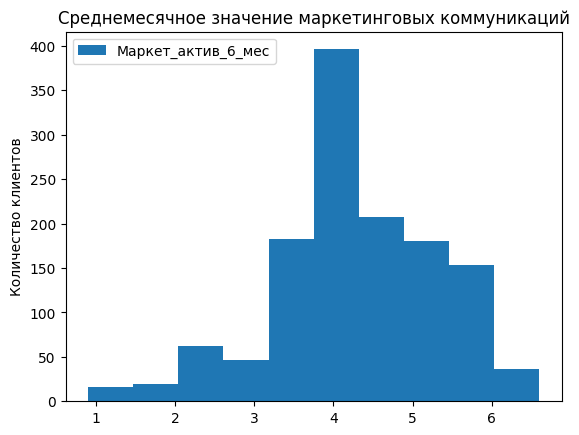

In [53]:
data_market_file.plot(kind='hist', y='Маркет_актив_6_мес', ylabel='Количество клиентов', title='Среднемесячное значение маркетинговых коммуникаций');

Мы видим, что среднее значение расположено рядом с модой, однако распределение несимметрично: правый хвост «тяжелее» левого,— что говорит о том,
что компания в отношении довольно широкого круга клиентов склонна увеличивать свою маркетинговую активность.

Посмотрим на распределение признака «Маркет_актив_тек_мес» (количество маркетинговых коммуникаций в текущем месяце).

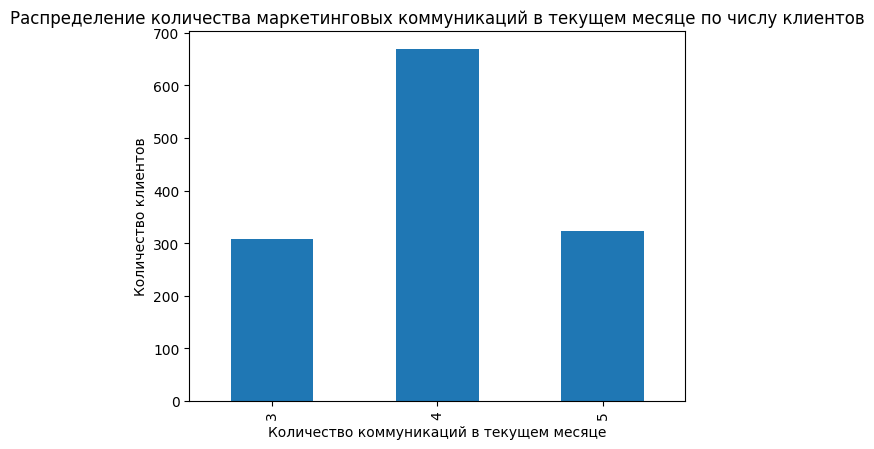

In [54]:
data_market_file['Маркет_актив_тек_мес'].value_counts().sort_index().plot(kind='bar', title='Распределение количества маркетинговых коммуникаций в текущем месяце по числу клиентов', xlabel='Количество коммуникаций в текущем месяце', ylabel='Количество клиентов');

А тут мы видим картину симметричную, т.е. среднее значение (оно же — мода) — 4 коммуникации в месяц, а остальных коммуникаций
(чуть больше — 5, и чуть меньше — 3) — примерно поровну.

Посмотрим на распределение признака «Длительность» (сколько дней прошло с момента регистрации покупателя на сайте).

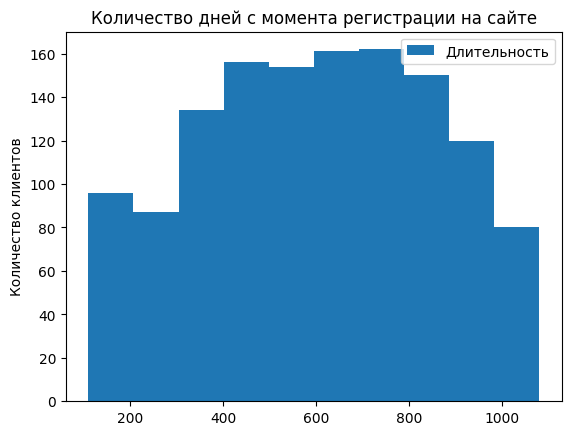

In [55]:
data_market_file.plot(kind='hist', y='Длительность', ylabel='Количество клиентов', title='Количество дней с момента регистрации на сайте');

Здесь мы видим, что в нашем датасете собраны данные клиентов, уже довольно давно пользующихся услугами нашего Интернет-магазина.
Подавляющее большинство зарегистрировалось на сайте более 6 месяцев назад (что соответствует другой информации в датасете, например, признаку «Маркет_актив_6_мес», который неявно говорит о том, что пользователи должны быть на сайте минимум 6 месяцев).
Большинство же пользователей зарегистрировалось больше года назад.

Посмотрим на распределение признака «Акционные_покупки» (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев)

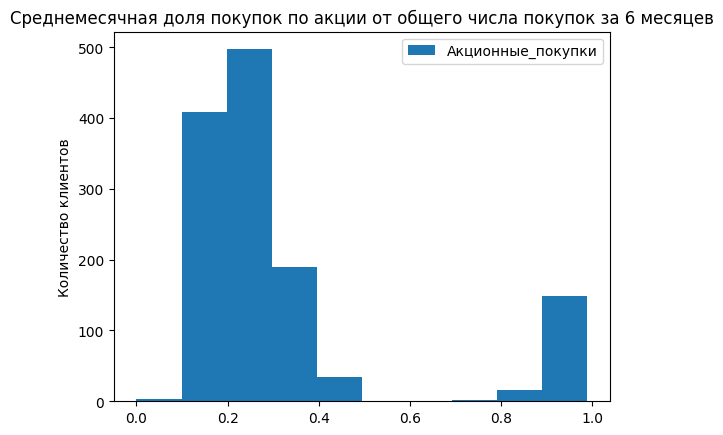

In [56]:
data_market_file \
    .plot(kind='hist',
          y='Акционные_покупки',
          ylabel='Количество клиентов',
          title='Среднемесячная доля покупок по акции от общего числа покупок за 6 месяцев');

Мы видим, что для большинства клиентов среднемесячная доля покупок по акции от общего числа покупок находится в пределах от 10 до 40 процентов.
При этом есть обособленная и значимая (более 150 человек) группа клиентов, которая практически все свои товары — более $80\%$ — покупает
по всевозможным акциям.

Посмотрим теперь на распределение признака «Средний_просмотр_категорий_за_визит» (сколько в среднем категорий покупатель просмотрел
за визит в течение последнего месяца)

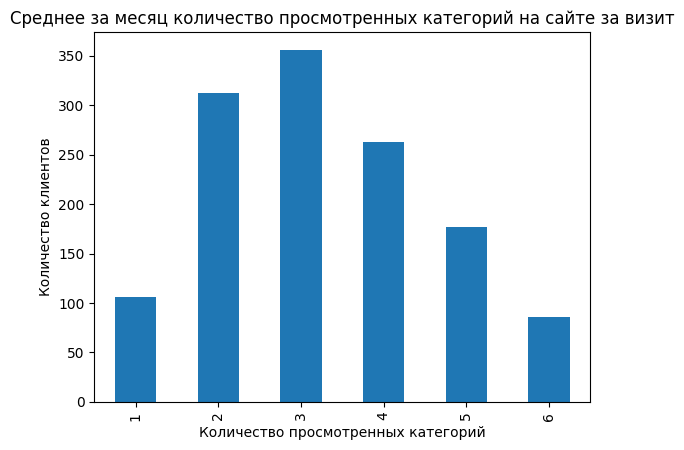

In [57]:
data_market_file['Средний_просмотр_категорий_за_визит'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar',
          xlabel='Количество просмотренных категорий',
          ylabel='Количество клиентов',
          title='Среднее за месяц количество просмотренных категорий на сайте за визит');

Мы видим, что большинство клиентов смотрит от 2 до 4 категорий за один визит.

Рассмотрим распределение признака «Неоплаченные_продукты_штук_квартал» (общее число неоплаченных товаров в корзине за последние 3 месяца)

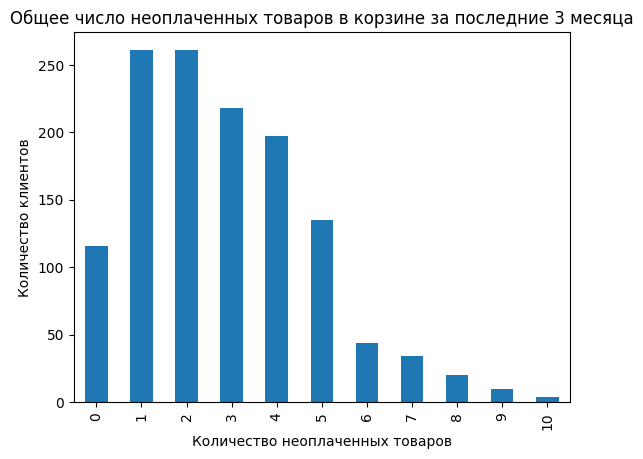

In [58]:
data_market_file['Неоплаченные_продукты_штук_квартал'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar',
          xlabel='Количество неоплаченных товаров',
          ylabel='Количество клиентов',
          title='Общее число неоплаченных товаров в корзине за последние 3 месяца');

Мы видим, что большинство клиентов имеет не больше пяти неоплаченных товаров в корзине на последние 3 месяца.

Рассмотрим распределение признака «Ошибка_сервиса» (число сбоев, которые коснулись покупателя во время посещения сайта).

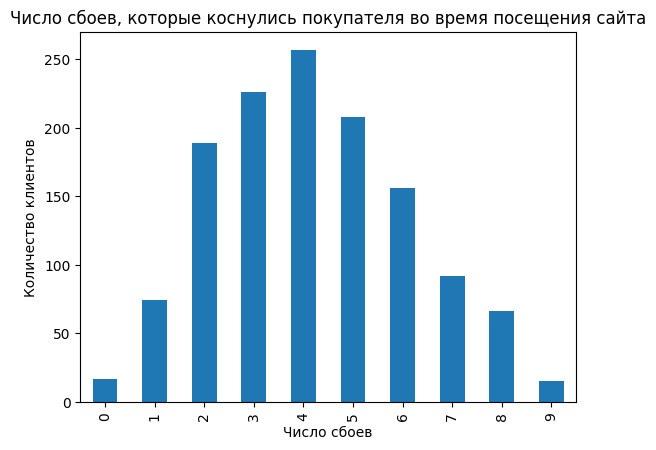

In [59]:
data_market_file['Ошибка_сервиса'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar',
          xlabel='Число сбоев',
          ylabel='Количество клиентов',
          title='Число сбоев, которые коснулись покупателя во время посещения сайта');

Тут распределение похоже на нормальное со средним в 4.
Проблема, судя по всему, чисто техническая и не имеет отношения к деятельности клиентов на сайте.

Посмотрим на распределение признака «Страниц_за_визит» (среднее количество страниц, которые просмотрел покупатель 
                                                        за один визит на сайт за последние 3 месяца)

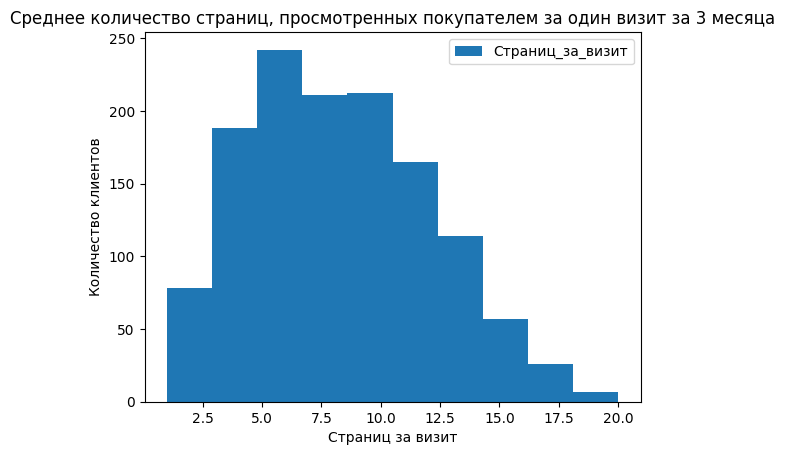

In [60]:
data_market_file \
    .plot(kind='hist',
          y='Страниц_за_визит',
          xlabel='Страниц за визит',
          ylabel='Количество клиентов',
          title='Среднее количество страниц, просмотренных покупателем за один визит за 3 месяца');

Мы видим, что подавляющее большинство пользоваателей просматривают в среднем больше 5 страниц за один визит на сайт.
Это говорит о том, что пользователи в целом лояльны к сайту и любят на нем посидеть.

Посмотрим теперь на распределение категориальных признаков.

Начнем с «Покупательская_активность».

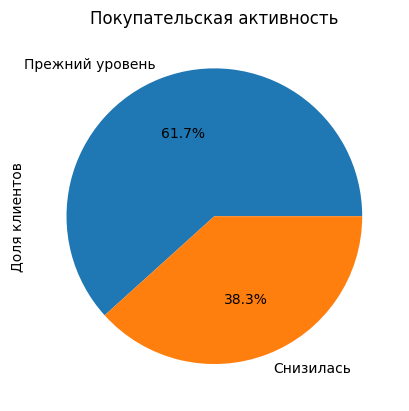

In [61]:
data_market_file['Покупательская_активность'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Доля клиентов', title='Покупательская активность', autopct='%1.1f%%');

Мы видим, что большинство пользователей все-таки склонно держать свою покупательскую активность на прежнем уровне.

Посмотрим теперь на признак «Тип_сервиса».

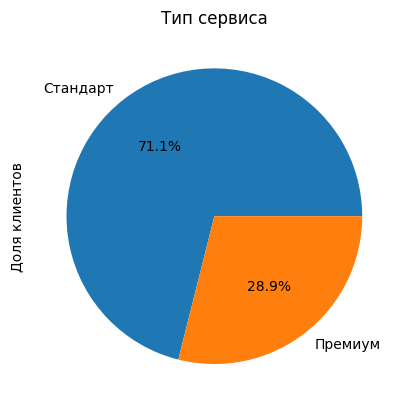

In [62]:
data_market_file['Тип_сервиса'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Доля клиентов', title='Тип сервиса', autopct='%1.1f%%');

Большинство пользователей пользуестя сервисом уровня «Стандарт».

Теперь посмотрим на признак «Разрешить_сообщать» (можно ли присылать покупателю с его согласия дополнительные предложения о товаре)

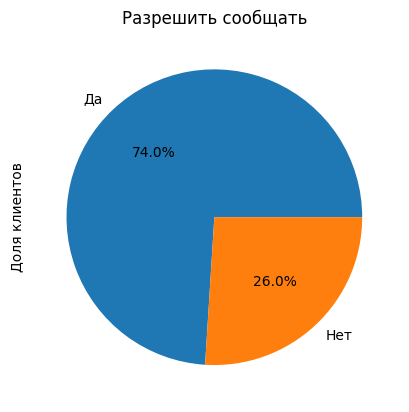

In [63]:
data_market_file['Разрешить_сообщать'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Доля клиентов', title='Разрешить сообщать', autopct='%1.1f%%');

Почти три четверти пользователей дали свое согласие на уведомления о новых товарных предложениях.

Посмотрим на распределение по товарным категориям («Популярная_категория»).

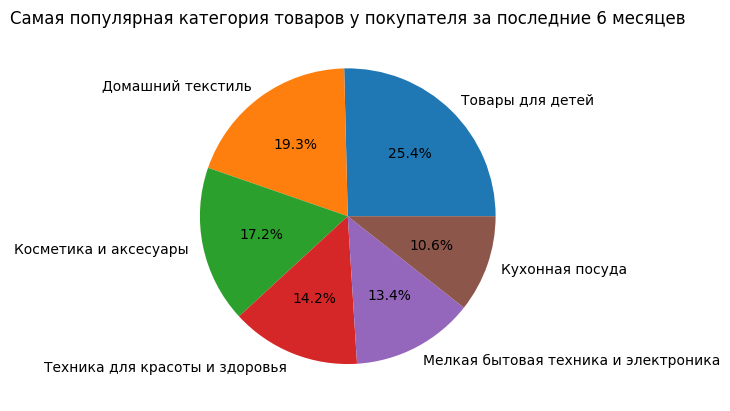

In [64]:
data_market_file['Популярная_категория'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Самая популярная категория товаров у покупателя за последние 6 месяцев', autopct='%1.1f%%');

Самая популярная категория — «Товары для детей», за ним следует «Домашний текстиль», замыкает тройку «Косметика и аксессуары».

#### market_money

In [65]:
data_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Взглянем на первые 5 строк

In [66]:
data_market_money.head()

,id,Период,Выручка
0,215348,Препредыдущий месяц,0.0
1,215348,Текущий месяц,3293.1
2,215348,Предыдущий месяц,0.0
3,215349,Препредыдущий месяц,4472.0
4,215349,Текущий месяц,4971.6


Рассмотрим описательную статистику числового признака «Выручка» (сумма выручки за период, т.е. за указанный месяц).

In [67]:
data_market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

Видим аномальное значение максимума выручки.
Построим диаграмму размаха для выручки.

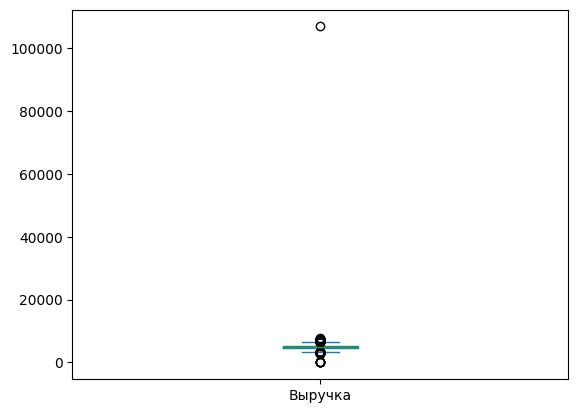

In [68]:
data_market_money['Выручка'].plot(kind='box', ylabel='');

Посмотрим на него и, заодно, на траты этого же пользователя в другие месяцы.

In [69]:
data_market_money[data_market_money['Выручка'] > 100000]

,id,Период,Выручка
98,215380,Текущий месяц,106862.2


In [70]:
data_market_money[data_market_money['id'] == 215380]

,id,Период,Выручка
96,215380,Препредыдущий месяц,5051.0
97,215380,Предыдущий месяц,6077.0
98,215380,Текущий месяц,106862.2


Видим, что остальные цифры выручки магазина с этого же клиента вполне нормальные, так что удалять клиента из выборки (как аномального) мы не будем.
Сама по себе цифра трат в 106 тыс. руб. в месяц вполне реальна (возможно, клиент купил себе что-то дорогое из мебели или электроники), однако она одна-единственна и выбивается даже из его же собственных трат за другие месяцы.
Эта цифра может ввести нашу потенциальную модель в заблуждение, поэтому заменим ее на максимальное значение из выборки без учета рассматриваемого нами значения.

In [71]:
data_market_money.loc[data_market_money['Выручка'] > 100000, 'Выручка'] = \
    data_market_money.loc[data_market_money['Выручка'] < 100000]['Выручка'].max()

Посмотрим на распределение этого числового признака («Выручка»).

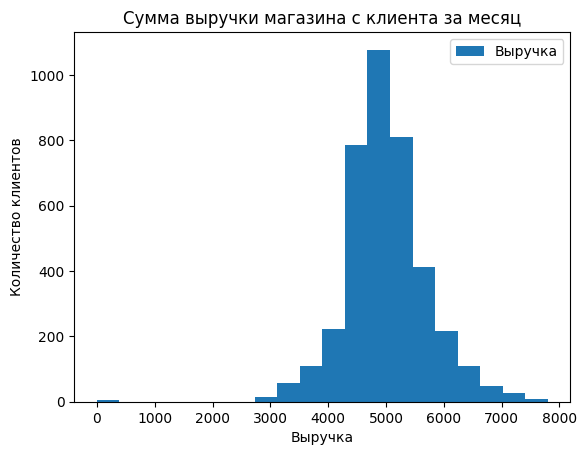

In [72]:
data_market_money \
    .plot(kind='hist',
          bins=20,
          y='Выручка',
          xlabel='Выручка',
          ylabel='Количество клиентов',
          title='Сумма выручки магазина с клиента за месяц');

Видим, что в целом у нас нормальное распределение.
Кроме того, обратим внимание, что практически нет клиентов с месячной выручкой, равной нулю, то есть клиент, зарегистрировавшись
на сайте, остается лоялен магазину и регулярно совершает там покупки.

Посмотрим на распределение категориального признака «Период» (период, во время которого зафиксирована выручка.)

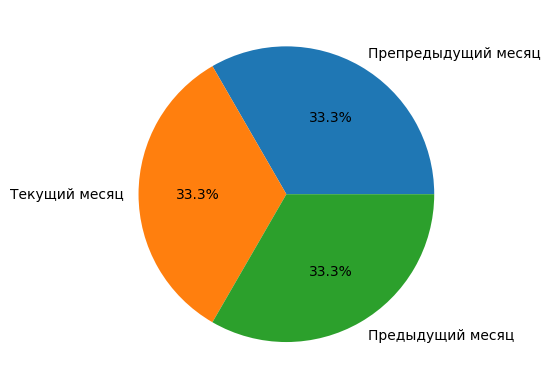

In [73]:
data_market_money['Период'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='', autopct='%1.1f%%');

Признак распределен равномерно.

#### market_time

In [74]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   Минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Взглянем на первые 5 строк

In [75]:
data_market_time.head()

,id,Период,Минут
0,215348,Текущий месяц,14
1,215348,Предыдущий месяц,13
2,215349,Текущий месяц,10
3,215349,Предыдущий месяц,12
4,215350,Текущий месяц,13


Рассмотрим описательную статистику числового признака «Минут»

In [76]:
data_market_time['Минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: Минут, dtype: float64

Видим, что выбросов нет.

Посмотрим на распределение категорий.

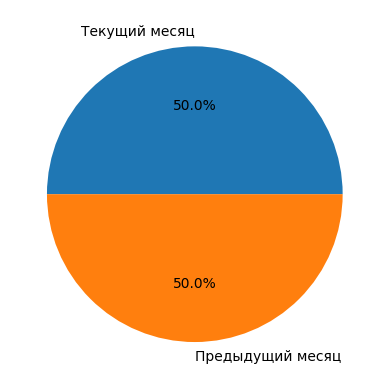

In [77]:
data_market_time['Период'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='', autopct='%1.1f%%');

Категории распределены равномерно.
В отличие от предыдущего датасета, в этом отсутствуют данные за препредыдущий месяц.

#### money

In [78]:
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Взглянем на первые 5 строк.

In [79]:
data_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Посмотрим на описательную статистику числового признака «Прибыль» (среднемесячная за последние 3 месяца прибыль магазина от продаж
каждому покупателю),

In [80]:
data_money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Видим наличие выбросов, однако аномальных данных нет.
Посмотрим на диаграмму размаха.

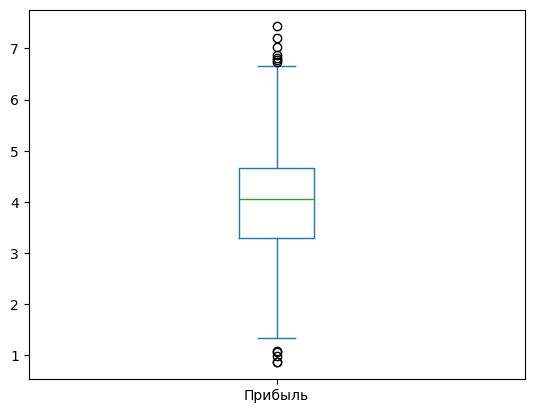

In [81]:
data_money['Прибыль'].plot(kind='box', ylabel='');

Выбросы вполне в пределах правдоподобных значений.

Рассмотрим распределние признака этого признака («Прибыль»)

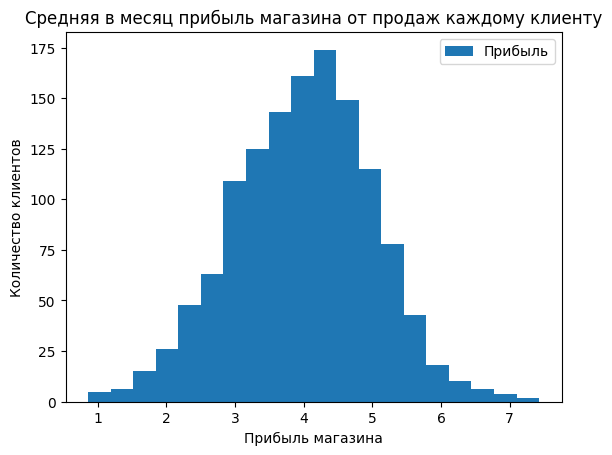

In [82]:
data_money \
    .plot(kind='hist',
          bins=20,
          y='Прибыль',
          xlabel='Прибыль магазина',
          ylabel='Количество клиентов',
          title='Средняя в месяц прибыль магазина от продаж каждому клиенту');

Распределение в целом имеет профиль нормального распределения.

### Отбор клиентов с покупательской активностью не менее 3 месяцев

Выделим клиентов, которые что-то покупали на сайте в каждый из последних трех месяцев.
Если вспомнить график распределения выручки в месяц, то таких клиентов должно быть абсолютное большинство.

In [83]:
all_active_ids = data_market_money[data_market_money['Выручка'] > 0]['id'].value_counts()

In [84]:
three_month_active_ids = all_active_ids.index[all_active_ids.isin([3])].tolist()

In [85]:
data_active_market_file = data_market_file.loc[data_market_file['id'].isin(three_month_active_ids), :]
data_active_market_file

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,Стандарт,Да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,Стандарт,Нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,Стандарт,Да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,Стандарт,Да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


Да, так и есть.
Почти все клиенты (кроме трех) имеют покупательскую активность, по крайней мере, три месяца.

В целом, мы видим, что данные в целом корректные и правдоподобные, практически без аномальных значений.

В датасетах содержатся данные пользователей, довольно давно зарегистрированные на сайте (большинство больше полугода), с регулярной
покупательской активностью за последние 3 месяца, что видно по сформированному в ходе анализа датасету (и по распределению признака «Выручка»).

## Объединение таблиц

Объединим данные датасетов data_active_market_file, data_market_money и data_market_time в общий датасет data_main.

In [86]:
data_active_market_money = data_market_money.loc[data_market_money['id'].isin(three_month_active_ids), :]

In [87]:
data_main = data_active_market_file.merge( \
    data_active_market_money[data_active_market_money['Период'] == 'Препредыдущий месяц'].loc[:, ['id', 'Выручка']], \
    on='id')

In [88]:
data_main = data_main.rename(columns={
    'Выручка': 'Выручка_Препредыдущий_месяц'
})

In [89]:
data_main = data_main.merge( \
    data_active_market_money[data_active_market_money['Период'] == 'Предыдущий месяц'].loc[:, ['id', 'Выручка']], \
    on='id')

In [90]:
data_main = data_main.rename(columns={
    'Выручка': 'Выручка_Предыдущий_месяц'
})

In [91]:
data_main = data_main.merge( \
    data_active_market_money[data_active_market_money['Период'] == 'Текущий месяц'].loc[:, ['id', 'Выручка']], \
    on='id')

In [92]:
data_main = data_main.rename(columns={
    'Выручка': 'Выручка_Текущий_месяц'
})

In [93]:
data_active_market_time = data_market_time.loc[data_market_time['id'].isin(three_month_active_ids), :]

In [94]:
data_main = data_main.merge( \
    data_active_market_time[data_active_market_time['Период'] == 'Предыдущий месяц'].loc[:, ['id', 'Минут']], \
    on='id')

In [95]:
data_main = data_main.rename(columns={
    'Минут': 'Минут_Предыдущий_месяц'
})

In [96]:
data_main = data_main.merge( \
    data_active_market_time[data_active_market_time['Период'] == 'Текущий месяц'].loc[:, ['id', 'Минут']], \
    on='id')

In [97]:
data_main = data_main.rename(columns={
    'Минут': 'Минут_Текущий_месяц'
})

Окончательно,

In [98]:
data_main

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_Препредыдущий_месяц,Выручка_Предыдущий_месяц,Выручка_Текущий_месяц,Минут_Предыдущий_месяц,Минут_Текущий_месяц
0,215349,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
1,215350,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
2,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
3,215352,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
4,215353,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,Стандарт,Да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7
1293,216644,Прежний уровень,Стандарт,Нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11
1294,216645,Прежний уровень,Стандарт,Да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18
1295,216646,Прежний уровень,Стандарт,Да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,5224.6,18,7


Датасет готов!

## Корреляционный анализ

Проведем корреляционный анализ признаков.
Так как целевой признак категориальный, для корреляционного анализа воспользуемся библиотекой phik.

In [99]:
interval_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
                 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
                 'Страниц_за_визит', 'Выручка_Препредыдущий_месяц', 'Выручка_Предыдущий_месяц', 'Выручка_Текущий_месяц',
                 'Минут_Предыдущий_месяц', 'Минут_Текущий_месяц']

phik_overview = phik_matrix(data_main.drop('id', axis=1), interval_cols=interval_cols) 

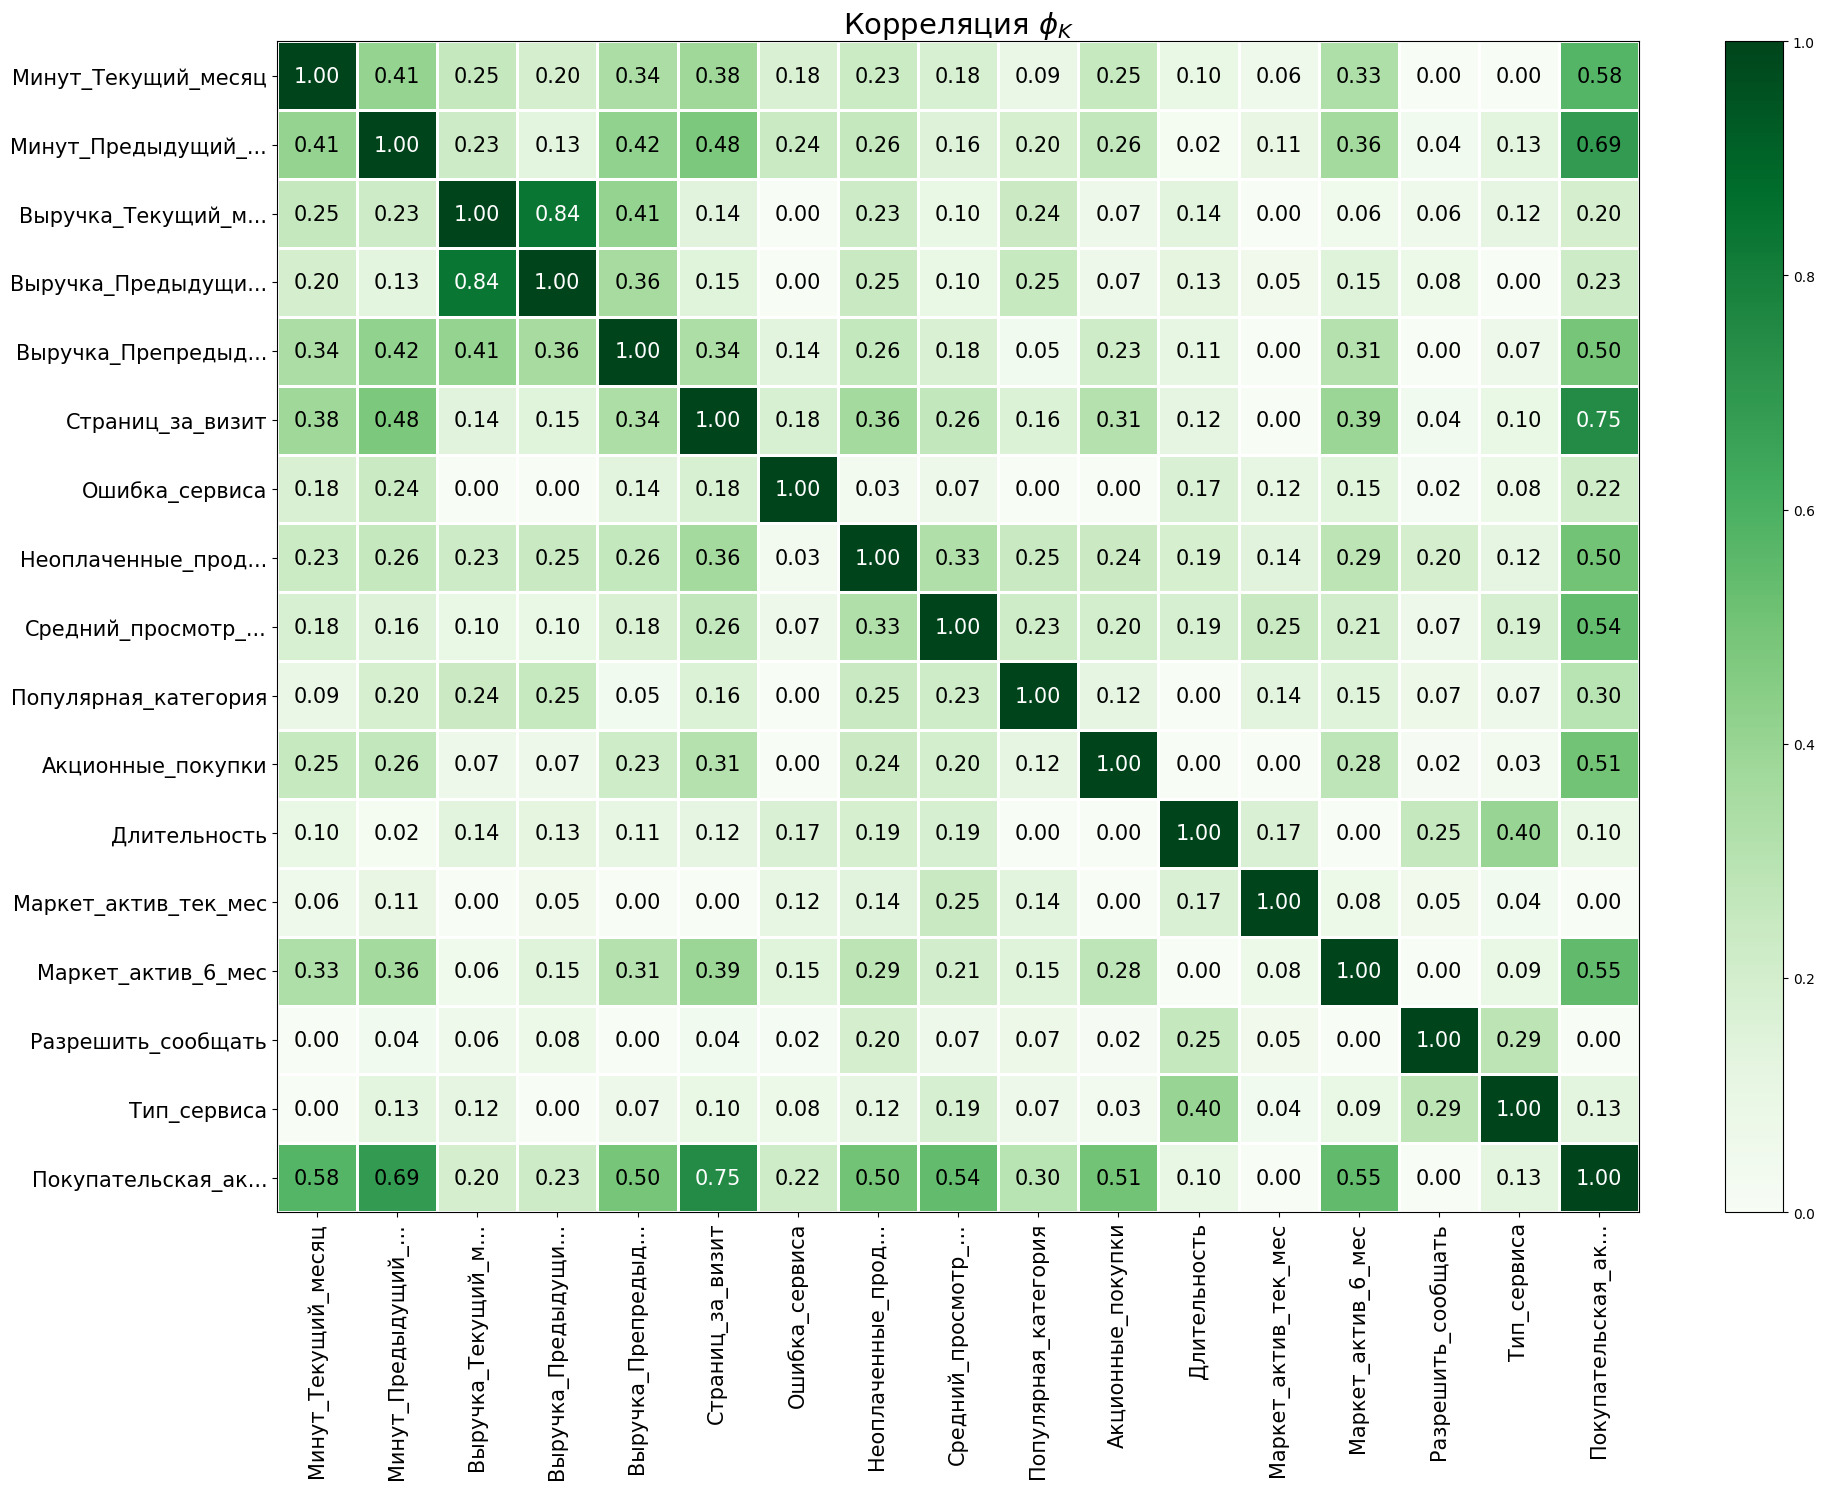

In [100]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видим, что у целевого признака («Покупательская_активность») самая сильная корреляция имеется с признаком «Страниц_за_визит»
(среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца);
умеренная корреляция (от 0.5 до 0.7) наблюдается с признаками «Минут_Предыдущий_месяц» (время, проведенное на сайте в минутах
за указанный месяц), «Минут_текущий_месяц», «Маркет_актив_6_мес» (среднемесячное значение маркетинговых коммуникаций),
«Средний_просмотр_категорий_за_визит», «Акционные_покупки», «Выручка_Препредыдущий_месяц», а также «Неоплаченные_продукты_штук_квартал»;
слабая (от 0.3 до 0.5) корреляция наблюдается с признаком «Популярная_категория».

Сильная мультиколлинеарность между признаками не наблюдается.

## Использование пайплайнов

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров.
В качестве метрики будем использовать ROC_AUC, т.к. она нечувствительна к дисбалансу классов (который у нас имеется, исходя из распределения
целевого признака «Покупательская_активность»).
Для сохранения пропорции классов в выборках будем использовать стратификацию.

Признаков-«порядковых категорий» (вроде оценок «плохо» - «нормально» - «хорошо») у нас нет.

In [101]:
X = data_main.drop(['id','Покупательская_активность'], axis=1)

In [102]:
y = data_main['Покупательская_активность']

In [103]:
RANDOM_STATE = 12345

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, stratify = y)

Создадим списки с признаками:

In [105]:
feature_num_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
                       'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
                       'Страниц_за_визит', 'Выручка_Препредыдущий_месяц', 'Выручка_Предыдущий_месяц', 'Выручка_Текущий_месяц',
                       'Минут_Предыдущий_месяц', 'Минут_Текущий_месяц']

In [106]:
feature_cat_cols = ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

Создадим пайплайн для подготовки категориальных признаков: заполнение пропусков и прямое кодирование

In [107]:
# В новой версии библиотеки sklearn изменено наименование "sparse" параметра OneHotEncoder (не как в теории).
# На всякий случай, добавил оба варианта

In [108]:
try:
    cat_cols_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)
except:
    cat_cols_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

Создадим общий пайплайн для подготовки данных

In [109]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', cat_cols_pipe, feature_cat_cols),
        ('num', MinMaxScaler(), feature_num_cols)
    ], 
    remainder='passthrough'
)

Создаем окончательный пайплайн.

In [110]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Словари для моделей

In [2]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
         'models': [KNeighborsClassifier()],
         'models__n_neighbors': range(2, 5),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
         'models': [LogisticRegression(
             random_state=RANDOM_STATE, 
             solver='liblinear', 
             penalty='l1'
         )],
         'models__C': range(1, 5),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(
            probability=True,
            kernel='linear',
            random_state=RANDOM_STATE
        )],
        'models__C': [0.01, 0.1, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

NameError: name 'DecisionTreeClassifier' is not defined

Запускаем автоматический подбор модели.

In [112]:
# Был выбран случайный поиск, т.к. полный перебор занимает слишком много времени.

In [113]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [114]:
randomized_search.fit(X_train, y_train);

/usr/lib64/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшая модель и ее параметры

In [115]:
print(randomized_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('num',

Лучшая модель: SVC с линейным ядром и коэффициентом $C$ («сила» модели), равном 0.1

Метрика лучшей модели на тренировочной выборке

In [116]:
print(randomized_search.best_score_)

0.9074057131511676


Посмотрим метрику на тестовой выборке

In [117]:
roc_auc_score(y_test, randomized_search.predict_proba(X_test)[:, 1])

np.float64(0.892112020542449)

Лучшая модель выбрана.

## Анализ важности признаков

Построим график общей значимости признаков по методу SHAP.

In [118]:
data_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

In [119]:
X_test_processed = data_preprocessor.transform(X_test)

In [120]:
X_test_processed = pd.DataFrame(X_test_processed, columns=data_preprocessor.get_feature_names_out())

In [121]:
model = randomized_search.best_estimator_.named_steps['models']

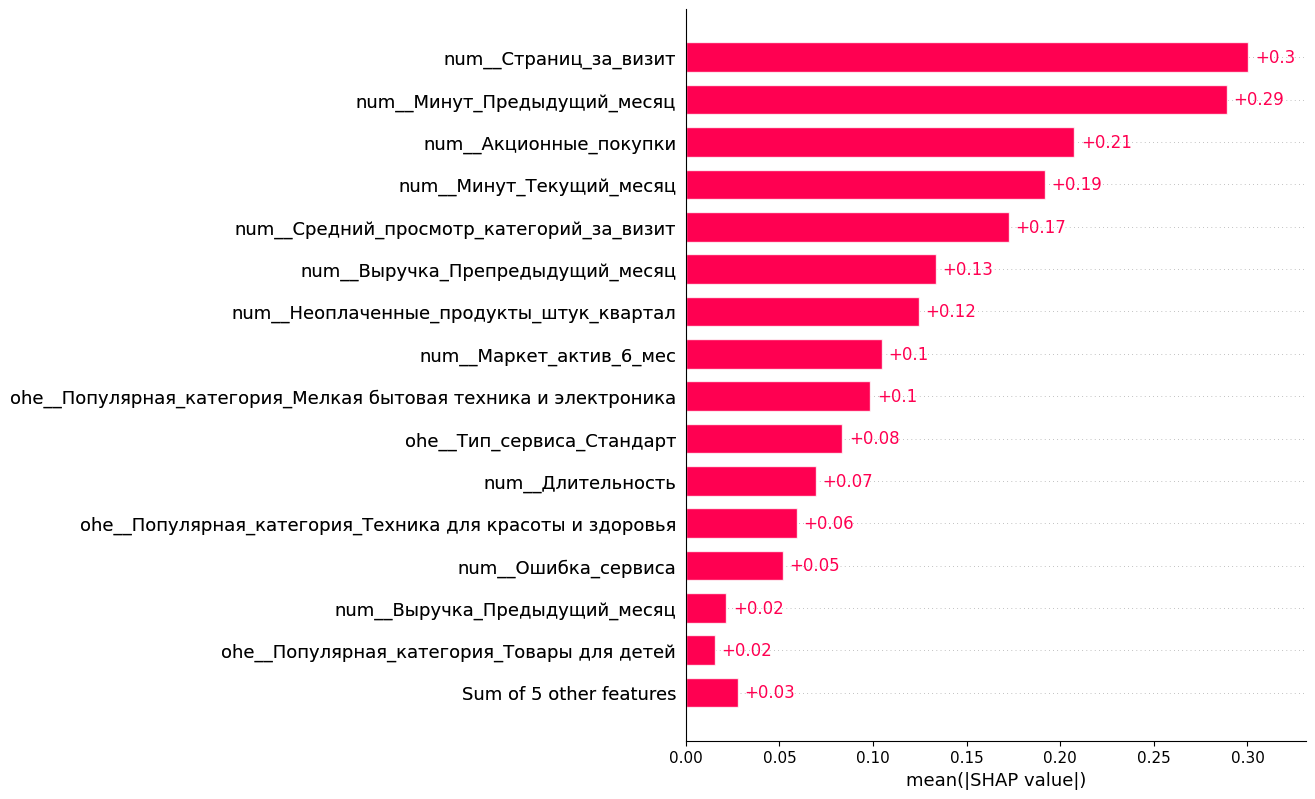

In [122]:
explainer = shap.LinearExplainer(model, X_test_processed)
shap_values = explainer(X_test_processed)
shap.plots.bar(shap_values, max_display=16) 

Построим диаграмму beeswarm, визуализирующую вклад признаков в каждое предсказание модели.

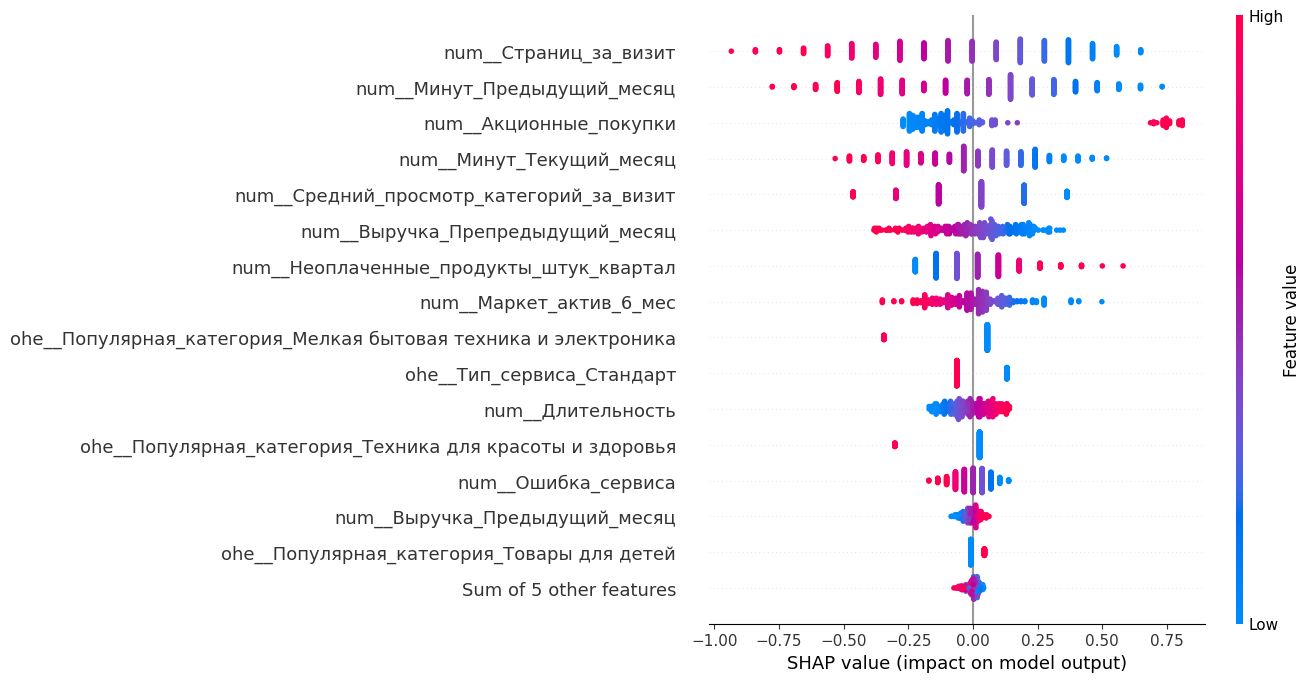

In [123]:
shap.plots.beeswarm(shap_values, max_display=16) 

10 самых значимых признаков, сильнее всего влияющих на предсказание модели:
* Страниц_за_визит (среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца)
* Минут_Предыдущий_месяц (значение времени, проведённого на сайте, в минутах за предыдущий месяц)
* Акционные_покупки (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев)
* Минут_Текущий_месяц (значение времени, проведённого на сайте, в минутах за текущий месяц)
* Средний_просмотр_категорий_за_визит (сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца)
* Выручка_препредыдущий_месяц (сумма выручки за препредыдущий месяц)
* Неоплаченные_продукты_штук_квартал (общее число неоплаченных товаров в корзине за последние 3 месяца)
* Маркет_актив_6_мес (среднемесячное значение маркетинговых коммуникаций компании)
* Популярная_категория_Мелкая бытовая техника и электроника (категория товаров "Мелкая бытовая техника и электроника")
* Тип_сервиса_Стандарт (стандартный тип сервиса)

5 признаков, менее влияющих на предсказание модели:
* Длительность (сколько дней прошло с момента регистрации покупателя на сайте)
* Популярная_категория_Техника для красоты и здоровья (категория товаров "Техника для красоты и здоровья")
* Ошибка_сервиса (число сбоев, которые коснулись покупателя во время посещения сайта)
* Выручка_Предыдущий_месяц (сумма выручки за предыдущий месяц)
* Популярная_категория_Товары для детей (категория товаров "Товары для детей")

При анализе диаграммы beeswarm мы видим. что высокое значение признаков, характеризующих взаимодействие клиента с сайтом магазина,
как-то: «Страниц_за_визит», «Минут_предыдущий_месяц», «Минут_Текущий_месяц», «Средний просмотр категорий за визит» — поаышают вероятность
отнесения клиента к классу 0 («Прежний уровень»).
Также вероятность отнесения клиента к классу 0 («Прежний уровень») увеличивают высокие значения признаков «Выручка_Препредыдущий_месяц»,
«Маркет_актив_6_мес».

Высокое значение признаков «Акционные_покупки» (среднемесячная доля покупок по акции от общего числа покупок),  «Неоплаченные_товары_штук_квартал» (неоплаченные товары в корзине), а также «Длительность» (время с момента регистрации на сайте) увеличивают вероятность отнесения клиента к классу 1 («Снизилась»).

При моделировании очень важен этап отбора признаков, т.к. чрезмерное усложнение признакового описания ведет к тому, что модели бывает трудно
разобраться какой признак влияет на целевой, а какой нет.
В этой саязи малозначимые признаки, вполне вероятно, являются избыточными и их удаление может привести к повышению качества модели.

При принятии бизнес-решений важно опираться на признаки, сильнее всего влияющие на целевой.
Например, бизнес может выработать решение, которое склонит пользователя к нужным действиям, которые должным образом повлияют на
максимизацию/минимизацию нужного признака, который, в свою очередь, повлияет на общее пользователя пользователя в интересах самого бизнеса
(например, удержит его Покупательскую активность на нужном уровне).

## Сегментация покупателей

В целом сегментацию покупателей можно выполнить по разным критериям.
Можно, например, отталкиваться от разных категорий товаров (разделить пользователей по категориям, исходя из их предпочтений к покупке
разных категорий товаров).
Можно также сегментировать пользователей по длительности их регистрации на сайте (условно «старые» пользователи и «новые»).
Применительно к нашей задаче такая сегментация может вызывать интерес, т.к. выше мы видим, что высокое значение признака «Длительность»
увеличивает вероятность отнесения пользователя к классу 1(снижение покупательской активности), т.е. старые клиенты реже пользуются
нашим ресурсом. Но сам признак «Длительность» не является таким уж важным.

Руководствуясь этой логикой, выше, при анализе признаков, мы увидели важность признака «Акционные_покупки» (среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев),— кроме того, высокие (вплоть до максимального) значения этого признака сильно увеличивают вероятность отнесения к классу 1 (снижение покупательской активности).
Это сочетание факторов заслуживает пристальное внимание.

Итак, выберем для анализа группу покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской
активности.

In [124]:
data_main_promo_clients = data_main[data_main['Акционные_покупки'] == data_main['Акционные_покупки'].max()]

Теперь сделаем прогноз нашей моделью покупательской активности и выберем тех, у кого вероятность «Снизилась» высока.
Формализуем понятие «высокая вероятность» установлением порога в $70\%$

Сначала проверим метки классов

In [125]:
randomized_search.classes_

array(['Прежний уровень', 'Снизилась'], dtype=object)

Видим, что «Прежний уровень» соответствует классу 0, а «Снизилась» — классу 1.
На всякий случай, проверим это непосредственно.

Получим прогноз вероятностей и соответственно расставленных меток и проверим любое значение (например, первое).

In [126]:
pd.DataFrame(randomized_search.predict_proba(data_main_promo_clients)) \
    .assign(Метки=randomized_search.predict(data_main_promo_clients)).iloc[:1]

,0,1,Метки
0,0.130551,0.869449,Снизилась


Видим, что класс 1 — действительно «Снизилась».

Теперь выполним сам прогноз.

In [127]:
data_main_promo_clients = data_main_promo_clients.assign(Покупательская_активность_вероятность = randomized_search.predict_proba(data_main_promo_clients)[:, 1])
data_main_promo_clients = data_main_promo_clients.assign(Покупательская_активность = pd.Series(randomized_search.predict_proba(data_main_promo_clients)[:, 1] > 0.7).map({True: 'Снизилась', False: 'Прежний уровень'}).tolist())

In [128]:
data_main_promo_clients_low_activity = data_main_promo_clients.query("Покупательская_активность == 'Снизилась'")
data_main_promo_clients_low_activity

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_Препредыдущий_месяц,Выручка_Предыдущий_месяц,Выручка_Текущий_месяц,Минут_Предыдущий_месяц,Минут_Текущий_месяц,Покупательская_активность_вероятность
2,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,0.869449
37,215388,Снизилась,Стандарт,Да,3.5,4,663,0.99,Домашний текстиль,4,2,2,2,4182.0,3188.0,3232.2,10,12,0.976039
94,215445,Снизилась,Стандарт,Нет,4.0,5,372,0.99,Косметика и аксесуары,1,6,6,5,4528.0,5186.5,5208.6,9,10,0.987055
112,215463,Снизилась,Стандарт,Нет,3.1,4,472,0.99,Домашний текстиль,2,6,3,3,4470.0,5196.0,5015.3,8,12,0.993034
132,215483,Снизилась,Стандарт,Да,3.9,5,855,0.99,Кухонная посуда,2,6,7,6,4834.0,6349.0,6355.5,8,8,0.984945
134,215485,Снизилась,Стандарт,Да,3.5,4,720,0.99,Косметика и аксесуары,1,2,4,7,4234.0,4201.0,5065.5,10,14,0.968004
142,215493,Снизилась,Стандарт,Да,4.0,5,881,0.99,Кухонная посуда,3,5,6,5,4870.0,6716.5,7799.4,9,10,0.969078
186,215537,Снизилась,Премиум,Да,3.9,4,705,0.99,Косметика и аксесуары,3,3,7,4,4974.0,6121.5,6781.9,7,9,0.981980
214,215565,Снизилась,Стандарт,Нет,2.4,4,522,0.99,Кухонная посуда,2,5,4,4,4492.0,4657.0,5104.2,11,12,0.983616
222,215573,Снизилась,Стандарт,Да,4.1,4,706,0.99,Кухонная посуда,2,6,2,6,4671.0,5418.0,5501.2,12,12,0.965140


Построим графики SHAP.

In [129]:
data_sample_processed = data_preprocessor.transform(data_main_promo_clients_low_activity)

In [130]:
data_sample_processed = pd.DataFrame(data_sample_processed, columns=data_preprocessor.get_feature_names_out())

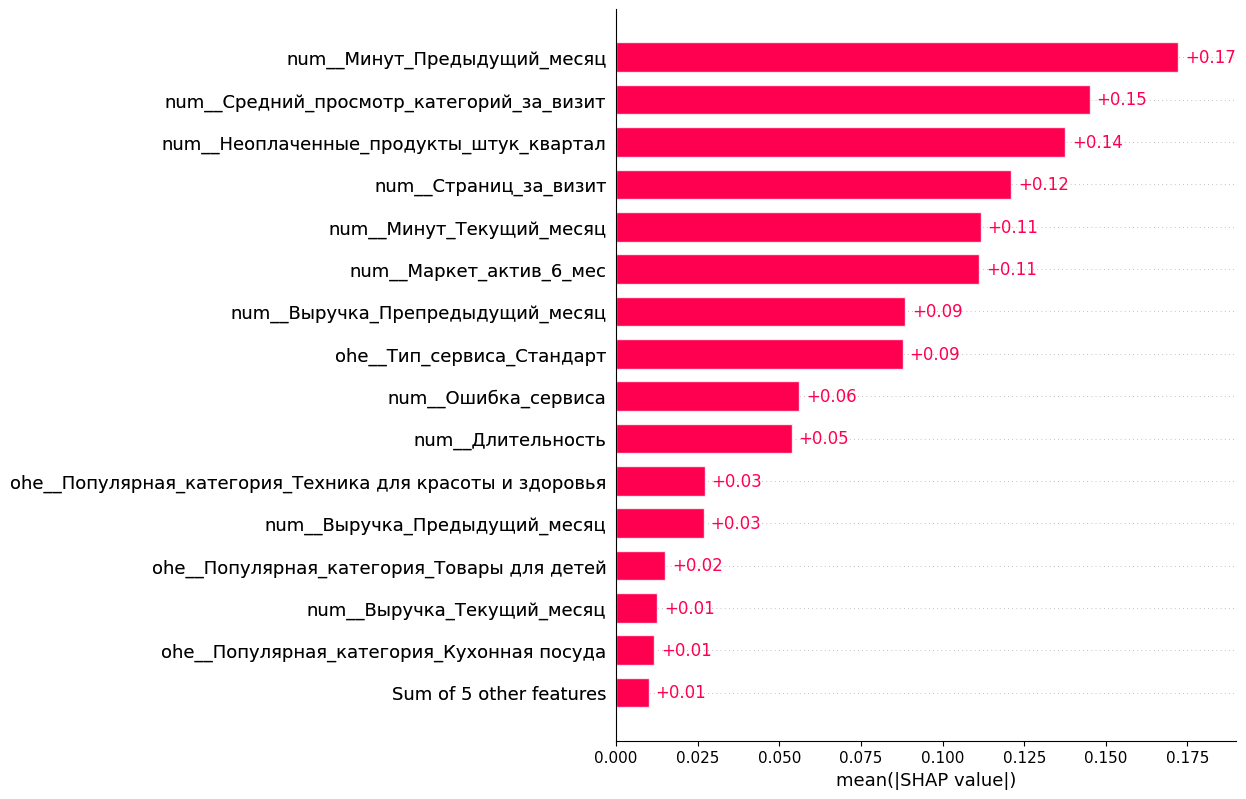

In [131]:
explainer = shap.LinearExplainer(model, data_sample_processed)
shap_values = explainer(data_sample_processed)
shap.plots.bar(shap_values, max_display=16) 

Построим диаграмму beeswarm, визуализирующую вклад признаков в каждое предсказание модели.

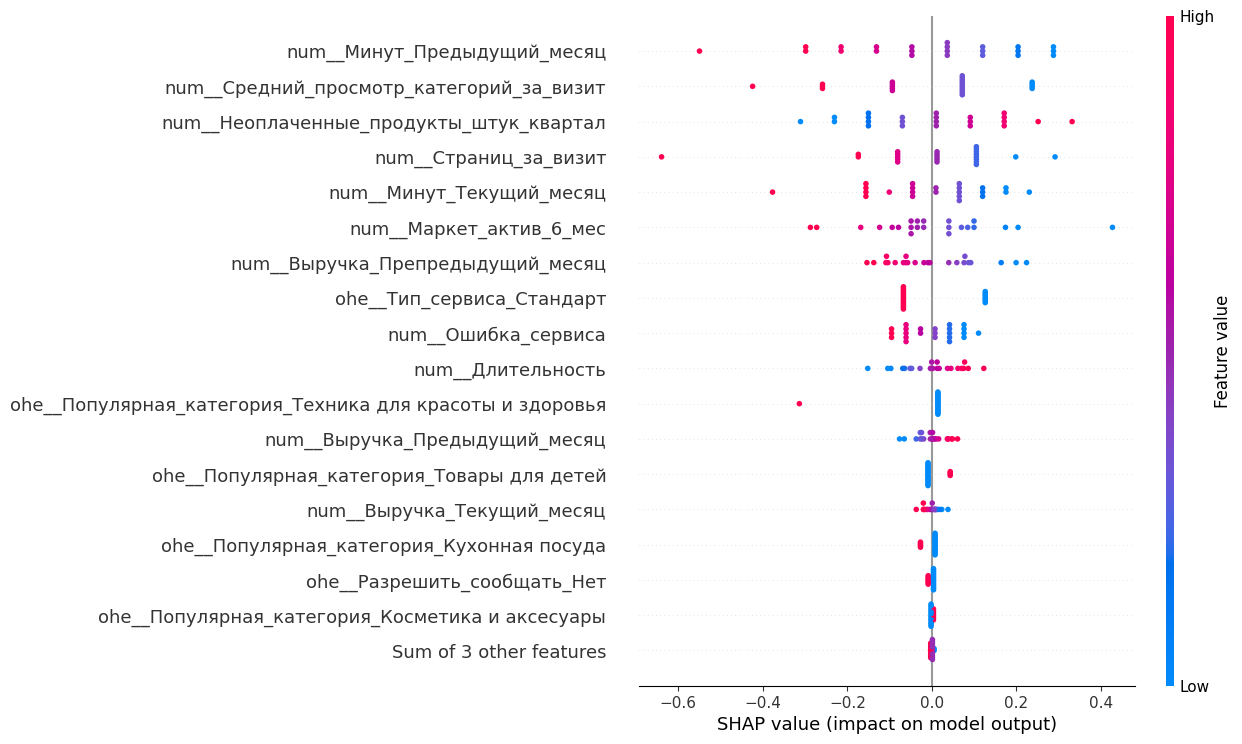

In [132]:
shap.plots.beeswarm(shap_values, max_display=18) 

Мы видим, что высокое значение признаков, характеризующих присутствие клиента на сайте («Минут_Предыдущий_месяц», «Средний_просмотр_категорий_за_визит», «Страниц_за_визит» и Минут_Текущий_месяц) повышают вероятность отнесения клиента к классу 0 («Прежний уровень»).
Кроме того, мы видим, что высокие значения признака «Неоплаченные_продукты_штук_квартал» повышают вероятность отнесения клиента к классу 1 («Снизилась»).
Еще видим, что высокие значения признаков «Маркет_актив_6_мес» и «Выручка_Препредыдущий_месяц» повышают вероятность отнесения клиента к классу «Прежний уровень».
Кроме того, стоит обратить внимание на признак «Длительность» — его высокие значения также увеличивают вероятность отнесения к классу «Снизилась».

В целом, лояльные пользователи с тенденцией на сохранение покупательской активности склонны много сидеть на сайте
(как следствие долгого времяпрепровождения там, у них большее количество увиденных ошибок сайта), быть активными участниками маркетинговых
программ (откуда они узнают о всяких скидках) и они, как правило, сразу оплачивают свой товар.

Рекомендации для удержания рассматриваемого сегмента пользователей можно предложить такие: 
* для всех клиентов из данного сегмента нужно увеличить персональную маркетинговую коммуникацию, предлагая интересный им товар по акции с
  учетом их предпочтений по категориям товаров
* для давних пользователей (с высоким показателем «Длительность») разработать систему персональных скидок с учетом их предпочтений по
  категориям товаров.
* для пользователей с тенденцией оставлять неоплаченные товары в корзине, можно разработать систему напоминаний об оплате товара.

Кроме того, для всех клиентов необходимо изучить их поведение на сайте и разработать такую систему переходов между страницами,
чтобы удержать их на сайте как можно дольше (чтобы была выше вероятность, что они встретят интересную им скидку или акцию).

Теперь оценим сегмент клиентов с прогнозом снижения покупательской активности и наиболее высокой прибыльностью.
Формализуем понятие высокая прибыльности 75$\%$м квартилем выборки и выберем клиентов с прибыльностью выше этого значения.

In [133]:
high_rev_client_ids = data_money[data_money['Прибыль'] > 4.67]['id'].tolist()

In [134]:
data_main_high_rev = data_main.loc[data_main['id'].isin(high_rev_client_ids), :]

Спрогнозируем для таких клиентов покупательскую активность и выберем тех, для которых модель спрогнозировала класс «Снизилась» (а также сформируем контрсегмент «Прежний уровень»)

In [135]:
data_main_high_rev = data_main_high_rev \
                                    .assign(Покупательская_активность_вероятность = \
                                                randomized_search.predict_proba(data_main_high_rev)[:, 1].tolist())

data_main_high_rev = data_main_high_rev \
                                    .assign(Покупательская_активность = \
                                                randomized_search.predict(data_main_high_rev).tolist())

In [136]:
data_main_high_rev_low_activity = data_main_high_rev.query("Покупательская_активность == 'Снизилась'")

In [137]:
data_main_high_rev_high_activity = data_main_high_rev.query("Покупательская_активность == 'Прежний уровень'")

Выборки по сегментам готовы!

Посмотрим графики SHAP

In [138]:
data_sample_processed = data_preprocessor.transform(data_main_high_rev)

In [139]:
data_sample_processed = pd.DataFrame(data_sample_processed, columns=data_preprocessor.get_feature_names_out())

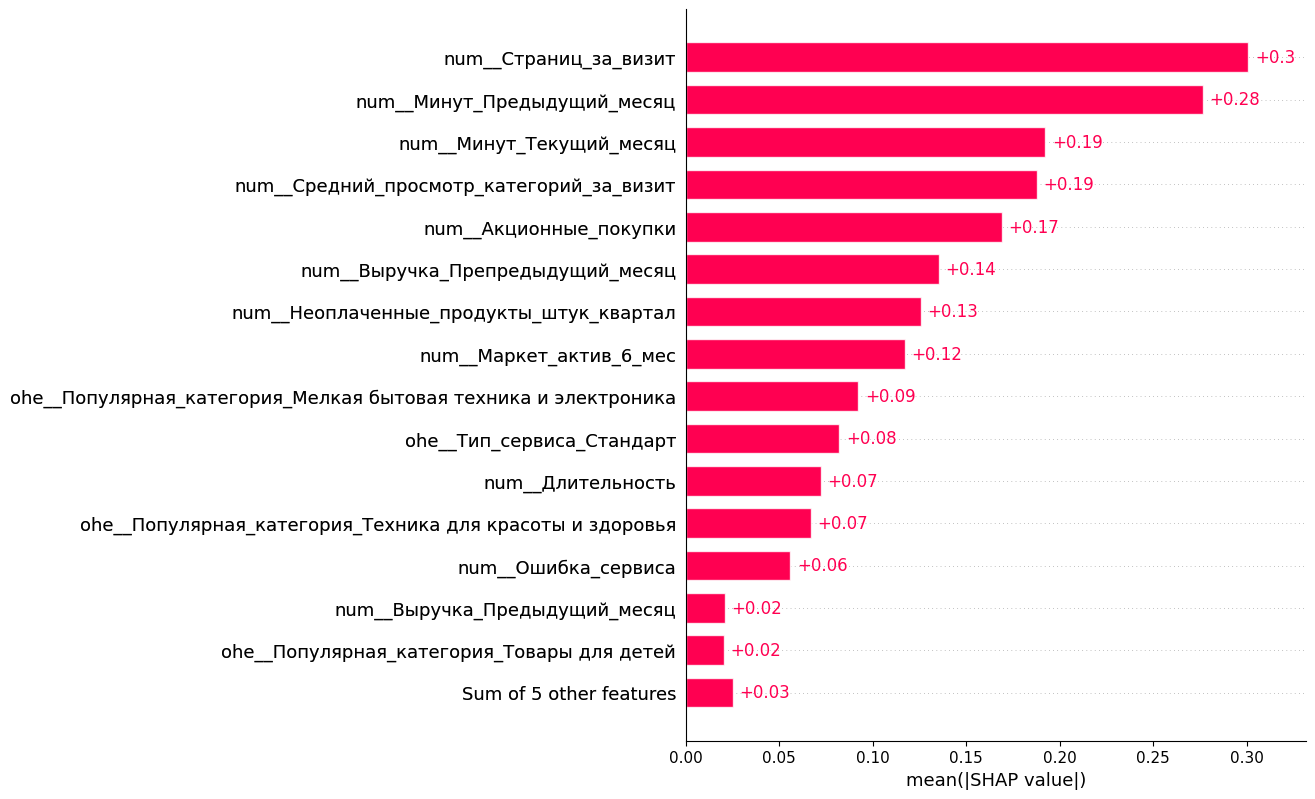

In [140]:
explainer = shap.LinearExplainer(model, data_sample_processed)
shap_values = explainer(data_sample_processed)
shap.plots.bar(shap_values, max_display=16) 

Построим диаграмму beeswarm, визуализирующую вклад признаков в каждое предсказание модели.

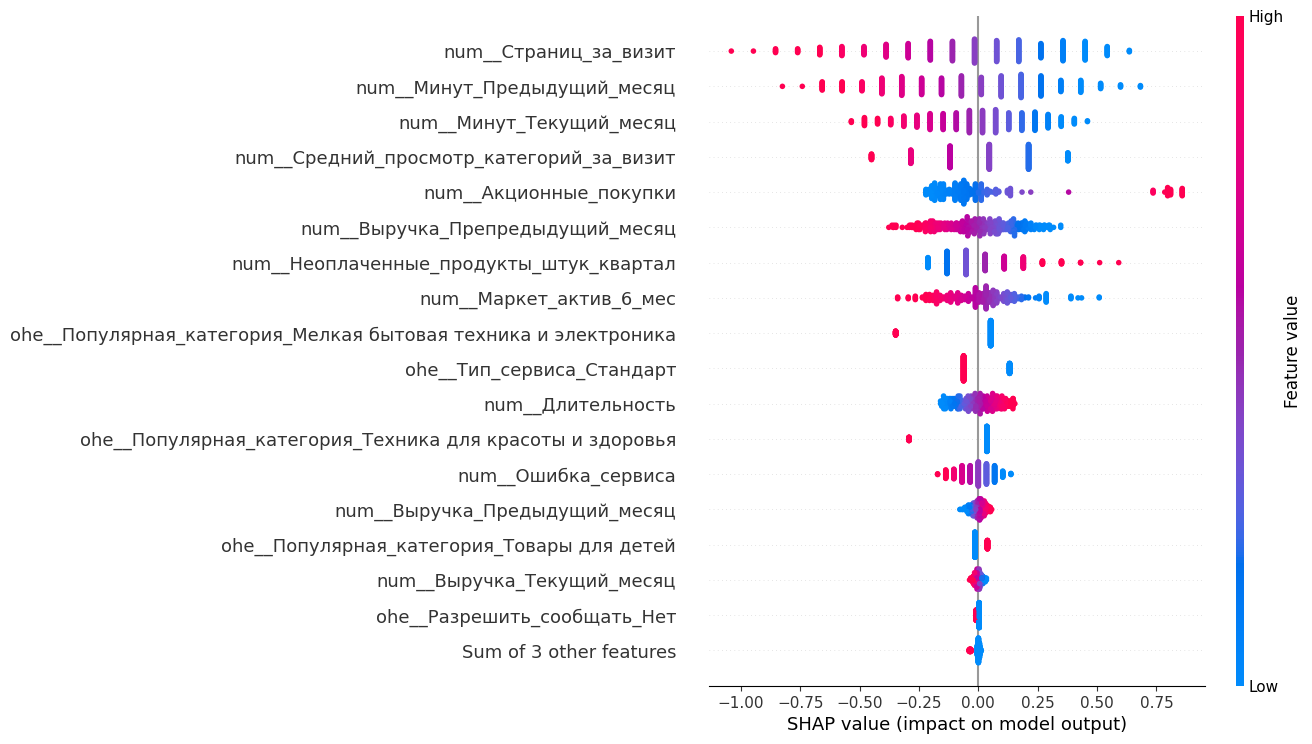

In [141]:
shap.plots.beeswarm(shap_values, max_display=18) 

В целом, видим картину, аналогичную изложенной в разделе об общем анализе важности признаков,— единственное, признак «Акционные_покупки» немного потерял в
значимости.

Построим описательную статистику для двух рассматриваемых нами сегментов.

In [142]:
data_main_high_rev_high_activity.drop(['id', 'Покупательская_активность_вероятность'], axis=1).describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_Препредыдущий_месяц,Выручка_Предыдущий_месяц,Выручка_Текущий_месяц,Минут_Предыдущий_месяц,Минут_Текущий_месяц
count,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,4.604846,3.903084,608.339207,0.232247,3.603524,2.167401,4.599119,9.801762,4964.515419,4917.894273,5112.012335,15.246696,14.929515
std,0.844882,0.684428,260.608723,0.145680,1.280067,1.530861,2.048656,3.417860,315.000230,611.835650,792.950666,3.343323,3.999376
min,2.600000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000,4339.000000,3130.000000,3085.400000,8.000000,5.000000
25%,3.950000,3.000000,387.000000,0.160000,3.000000,1.000000,3.000000,7.000000,4738.500000,4501.000000,4714.100000,13.000000,12.000000
50%,4.400000,4.000000,617.000000,0.210000,4.000000,2.000000,4.000000,9.000000,4962.000000,4943.000000,5088.100000,15.000000,15.000000
75%,5.300000,4.000000,822.500000,0.250000,5.000000,3.000000,6.000000,12.000000,5217.500000,5301.500000,5530.900000,18.000000,18.000000
max,6.600000,5.000000,1061.000000,0.990000,6.000000,7.000000,9.000000,19.000000,5637.000000,6359.000000,7410.000000,23.000000,23.000000


In [143]:
data_main_high_rev_low_activity.drop(['id', 'Покупательская_активность_вероятность'], axis=1).describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_Препредыдущий_месяц,Выручка_Предыдущий_месяц,Выручка_Текущий_месяц,Минут_Предыдущий_месяц,Минут_Текущий_месяц
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,3.528125,4.041667,613.166667,0.452917,2.416667,4.00000,3.708333,4.354167,4590.718750,4907.364583,5261.519792,9.927083,10.114583
std,0.976536,0.724266,255.905191,0.294882,1.130130,2.15211,1.794240,2.015619,245.678382,803.762624,865.623255,2.371963,2.466064
min,0.900000,3.000000,152.000000,0.120000,1.000000,0.00000,1.000000,1.000000,4119.000000,2909.000000,3078.300000,5.000000,5.000000
25%,3.075000,4.000000,404.250000,0.240000,2.000000,2.00000,2.000000,3.000000,4427.500000,4245.875000,4584.025000,8.750000,9.000000
50%,3.800000,4.000000,664.500000,0.320000,2.000000,4.00000,3.000000,4.000000,4616.500000,5048.500000,5317.300000,10.000000,10.000000
75%,4.100000,5.000000,810.000000,0.522500,3.000000,5.00000,5.000000,6.000000,4742.000000,5549.750000,5978.525000,11.000000,12.000000
max,5.600000,5.000000,1073.000000,0.990000,6.000000,10.00000,8.000000,11.000000,5267.000000,6227.000000,7063.000000,17.000000,18.000000


Помимо признаков, характеризующих то или иное взаимодействие пользователя с сайтом («Средний_просмотр_категорий_за_визит»,
«Страниц_за_визит», «Минут_Предыдущий_месяц» и т.д.), обращают на себя внимание 3 признака с существенно разным распределением:
«Маркет_актив_6_мес», «Акционные_покупки» и «Неоплаченные_продукты_штук_квартал»).
Построим диаграммы размаха для них.

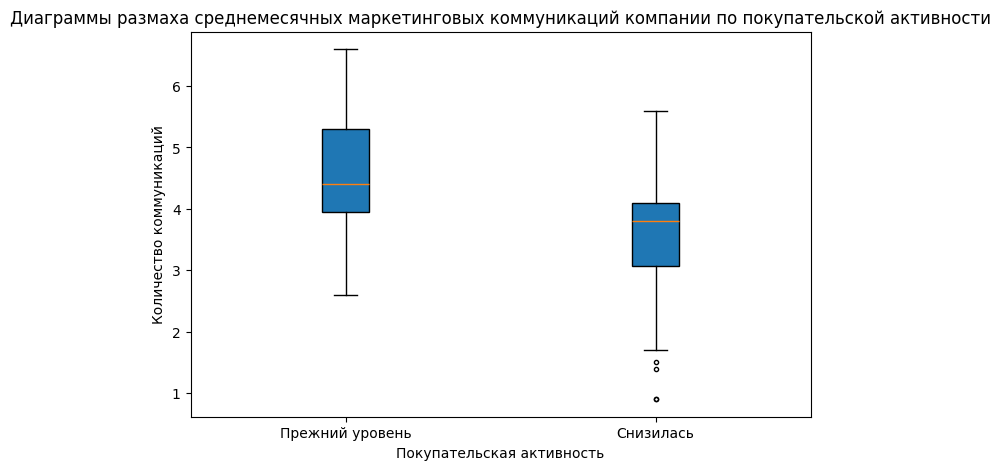

In [144]:
data_market_activity_6_month = {}

data_market_activity_6_month['Прежний уровень'] = data_main_high_rev_high_activity['Маркет_актив_6_мес']
data_market_activity_6_month['Снизилась'] = data_main_high_rev_low_activity['Маркет_актив_6_мес']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_market_activity_6_month.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_market_activity_6_month.keys())
ax.set_title('Диаграммы размаха среднемесячных маркетинговых коммуникаций компании по покупательской активности')
ax.set_xlabel('Покупательская активность')
ax.set_ylabel('Количество коммуникаций')
plt.show()

Мы видим, что у $75\%$ выборки пользоваателей с классом «Прежний уровень» число маркентинговых коммуникаций в среднем выше 4, тогда как
среди пользователей класса «Снизилась» таких меньше половины.

Теперь посмотрим на диаграмму размаха для «Акционные_покупки».

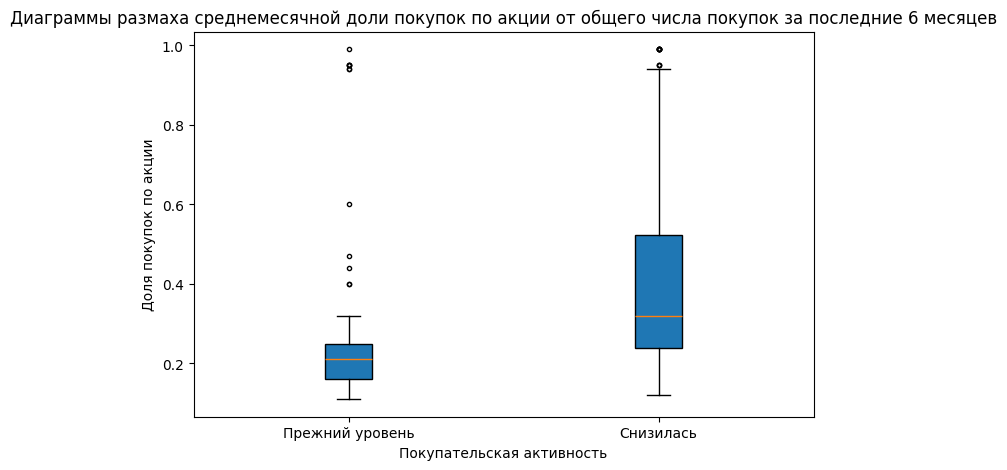

In [145]:
data_promo_activity = {}

data_promo_activity['Прежний уровень'] = data_main_high_rev_high_activity['Акционные_покупки']
data_promo_activity['Снизилась'] = data_main_high_rev_low_activity['Акционные_покупки']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_promo_activity.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_promo_activity.keys())
ax.set_title('Диаграммы размаха среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев')
ax.set_xlabel('Покупательская активность')
ax.set_ylabel('Доля покупок по акции')
plt.show()

Тут мы видим, что для $75\%$ клиентов из класса «Снизилась» доля покупок по акциям выше аналогичного показателя почти что у $75\%$
пользователей из класса 0 («Прежний уровень»).

То есть клиенты из класса «Снизилась» многие свои товары покупают по всевозможным акциям, заходя на сайт, во многом, именно для этого
(у них намного хуже показатели, характеризующие взаимодействие с сайтом) — они не ищут новые товары.

Посмотрим на диаграмму размаха для «Неоплаченные_продукты_штук_квартал»

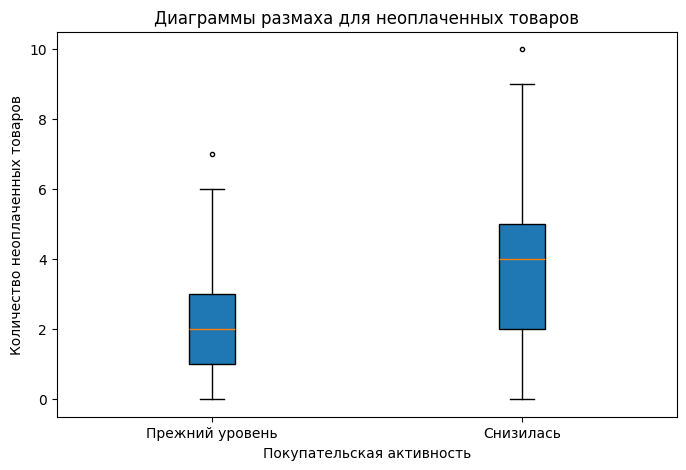

In [146]:
data_market_not_paid = {}

data_market_not_paid['Прежний уровень'] = data_main_high_rev_high_activity['Неоплаченные_продукты_штук_квартал']
data_market_not_paid['Снизилась'] = data_main_high_rev_low_activity['Неоплаченные_продукты_штук_квартал']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_market_not_paid.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_market_not_paid.keys())
ax.set_title('Диаграммы размаха для неоплаченных товаров')
ax.set_xlabel('Покупательская активность')
ax.set_ylabel('Количество неоплаченных товаров')
plt.show()

Неоплаченных товаров у $75\%$ клиентов из класса «Снизилась» больше, чем у половины пользователей из класса «Прежний уровень».

То есть такие клиенты, судя по всему, заходят на сайт, покупают там нужный им товар по акции (они, как правило, весьма краткосрочные)
и уходят, теряя интерес к поиску нужных им товаров, на которые акций нет.
Получается в некоторым смысле замкнутая система — пользователь вертится в пространстве скидок и акций, которые распространяются лишь
ограниченный набор товаров.

Корзины товаров у этих сегментов должны различаться.

Посмотрим на распределение категорий товаров в корзинах клиентов обоих сегментов.

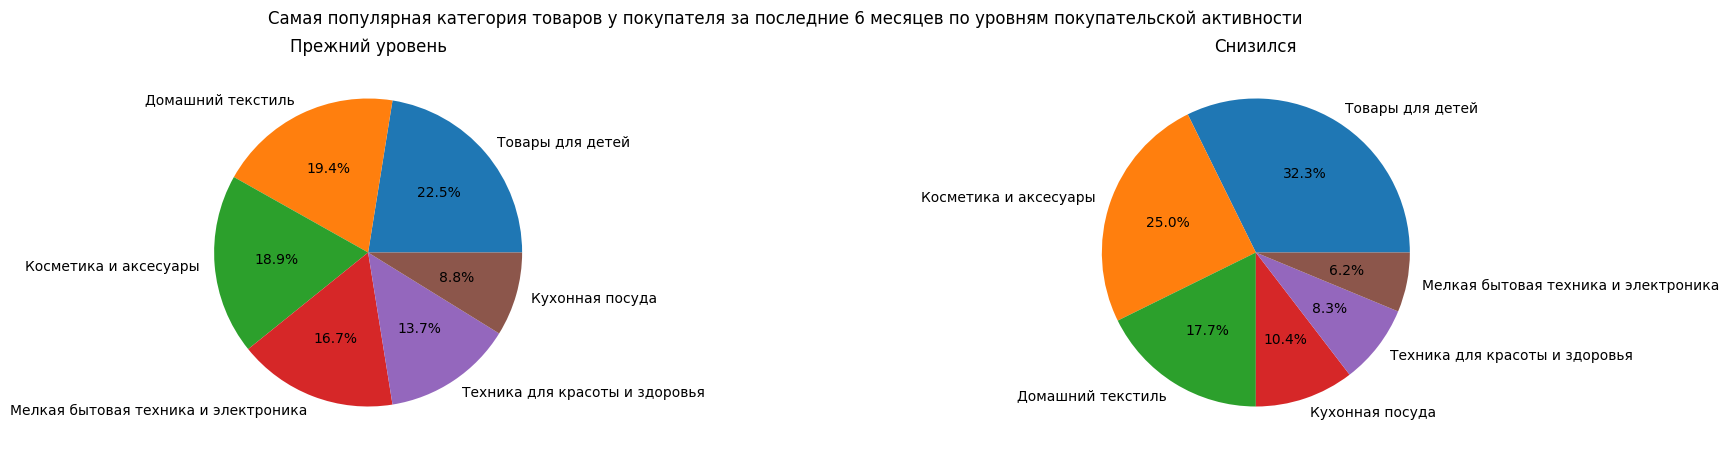

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(21, 5))
fig.suptitle('Самая популярная категория товаров у покупателя за последние 6 месяцев по уровням покупательской активности')

data_main_high_rev_high_activity['Популярная_категория'] \
    .value_counts() \
    .plot(ax=ax[0], kind='pie', ylabel='', title='Прежний уровень', autopct='%1.1f%%');

data_main_high_rev_low_activity['Популярная_категория'] \
    .value_counts() \
    .plot(ax=ax[1], kind='pie', ylabel='', title='Снизился', autopct='%1.1f%%');

И действительно: мы видим, что структура корзины у клиентов с прогнозом на сохранение покупательской активности существенно отличается от таковой у клиентов с прогнозом на снижение покупательской активности.
В частности, доля категорий «Мелкая бытовая техника и электроника», а также «Техника для красоты и здоровья» суммарно составляют $30.4\%$
корзины клиентов из класса 0 («Прежний уровень») против аналогичного показателя всего в $14.5\%$ у клиентов из класса 1 («Снизилась»).
Также, доля «Домашнего текстиля» у клиентов из класса 0 («Прежний уровень») тоже выше аналогичной доли из класса 1 (активность «Снизилась»).

Мы можем вспомнить, что маркетинговая активность у клиентов из класса 0 («Прежний уровень») тоже выше, при этом распределение признака
«Разрешить сообщать» примерно одинаковое (у пользователей с прогнозом на снижение покупательской активности она даже выше — через нее они
и узнают о всевозможных акциях и т.д.).

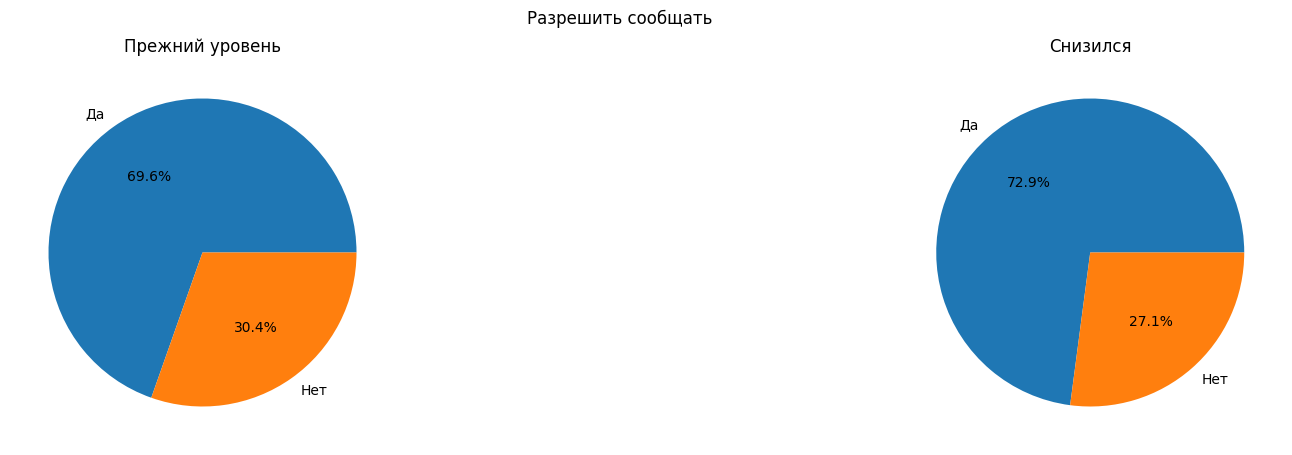

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(21, 5))
fig.suptitle('Разрешить сообщать')

data_main_high_rev_high_activity['Разрешить_сообщать'] \
    .value_counts() \
    .plot(ax=ax[0], kind='pie', ylabel='', title='Прежний уровень', autopct='%1.1f%%');

data_main_high_rev_low_activity['Разрешить_сообщать'] \
    .value_counts() \
    .plot(ax=ax[1], kind='pie', ylabel='', title='Снизился', autopct='%1.1f%%');

Таким образом, в вопросе маркентинговой активности применительно к клиентам из класса «Снизился» недорабатывает сама компания.
Есть зазор и возможность для увеличения маркентиговых усилий.

Рекомендации для удержания рассматриваемой нами группы пользователей можно предложить следующие:
* Для них необходимо разработать маркетинговую кампанию с системой персональных скидок (т.к. они любят акции) на новые категории товаров,
    к которым они ранее интереса не проявляли либо не было акций на них. Желательно увеличить долю категорий «Мелкая бытовая техника» (этот признак входит в десятку
    самых важных по SHAP), а также «Техника для красоты и здоровья» (по степени важности признака на три позиции ниже предыдущего).
* Для этих пользователей необходимо персонализировать их опыт взаимодействия с сайтом и разработать такую систему переходов между страницами,
  чтобы удержать их на сайте как можно дольше (предлагая им товары как из интересных им изначально, так и из вышеуказанных категорий — тут должен быть
  индивидуальный баланс).
* Для пользователей, которые имеют неоплаченные товары в магазине, необходимо разработать систему напоминаний об оплате товара (опять же,
  сопровождая рекламой и скидками на интересные им и новые категории товаров).

## Общий вывод

Мы работаем в Интернет-магазине «В один клик», который продает разные товары: для детей, для дома, мепкую бытовую технику, косметику,
продукты и прочее.
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.
Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории.
Возможный выход — удерживать активность постоянных клиентов. 
Сделать это можно с помощью персонализированных предложений.

#### Постановка задачи

Нам необходимо разрботать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую
активность.

#### Описание данных

Мы имеем 4 (четыре) датасета:
* market_file.csv — датасет, который содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом
  поведении.
* market_money.csv — датасет с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период
  взаимодействия с сайтом.
* market_time.csv — датасет с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* money.csv — датасет с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому
  покупателю.

#### Анализ данных

На этапе предобработки данных мы столкнулись со следующими проблемами:
* Названия столбцов и значений в них не были единообразными и могли привести к путанице. Все они были приведены к единообразному стилю.
* Были устранены неявные дубликаты значений признаков.

Был выполнен исследовательский анализ данных, в ходе которого были проверены выбросы и аномальные значения в данных,
изучены и проанализированы распределения признаков, а также были отобраны клиенты с покупательской активностью не менее трех месяцев.

Для поиска лучшей модели был использован общий пайплайн для четырех моделей с подбором гиперпараметров.
Для каждой модели был подобран минимум один гиперпараметр, для некоторых — два.
Лучшая модель — SVC с линейным ядром и коэффициентом $C$ («сила» модели), равным 0.1.

Был выбран сегмент пользователей «группа клиентов с максимальной долей покупок по акции и высокой вероятностью
снижения покупательской активности».
В ходе анализа этого сегмента были выработаны следующие рекомендации для удержания покупательской активности пользователей на прежнем уровне:
* для всех клиентов из данного сегмента нужно увеличить персональную маркетинговую коммуникацию, предлагая интересный им товар по акции
* для всех клиентов необходимо изучить их поведение на сайте и разработать такую систему переходов между страницами, чтобы
  удержать их на сайте как можно дольше (чтобы была выше вероятность, что они встретят интересную им скидку или акцию).
* для давних пользователей (с высоким покзаателем «Длительность») разработать систему персональных скидок с учетом их предпочтений по
  категориям товаров.
* для пользователей с тенденцией оставлять неоплаченные товары в корзине, можно разработать систему напоминаний об оплате товара.

Был также проанализирован сегмент пользователей с высокой прибыльностью, но с прогнозом снижения покупательской активности против
контрсегмента высокоприбыльных пользователей с прогнозом удержания прежнего уровня покупательской активности. В ходе анализа были выработаны
следующие рекомендации для удержания покупательской активности рассматриваемого нами сегмента на прежнем уровне:
* Для них необходимо разработать маркетинговую кампанию с системой персональных скидок (т.к. они любят акции) на новые категории товаров,
    к которым они ранее интереса не проявляли либо не было акций на них. Желательно увеличить долю категорий «Мелкая бытовая техника» (этот признак входит в десятку
    самых важных по SHAP), а также «Техника для красоты и здоровья» (по степени важности признака на три позиции ниже предыдущего).
* Для этих пользователей необходимо персонализировать их опыт взаимодействия с сайтом и разработать такую систему переходов между страницами,
  чтобы удержать их на сайте как можно дольше (предлагая им товары как из интересных им изначально, так и из вышеуказанных категорий — тут должен быть
  индивидуальный баланс).
* Для пользователей, которые имеют неоплаченные товары в магазине, необходимо разработать систему напоминаний об оплате товара (опять же,
  сопровождая рекламой и скидками на интересные им и новые категории товаров).